# Modelo de Riesgos Proporcionales Bayesiano.

In [3]:
# Cargamos las librerias
import pandas as pd
import numpy as np
from cmdstanpy import cmdstan_path, cmdstan_version, CmdStanModel
import arviz as az
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [4]:
# Funciones útiles
def show_stan_model(model_code):
    return Markdown(f'```stan\n{model_code}\n```')

In [5]:
# Cargamos los datos
data = pd.read_csv("COVID19MEXICO2022_muestra_clean.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2892 entries, 0 to 2891
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sexo            2892 non-null   int64  
 1   tipo_paciente   2892 non-null   int64  
 2   fecha_ingreso   2892 non-null   object 
 3   fecha_sintomas  2892 non-null   object 
 4   fecha_def       486 non-null    object 
 5   neumonia        2882 non-null   float64
 6   edad            2892 non-null   int64  
 7   nacionalidad    2892 non-null   int64  
 8   indigena        2779 non-null   float64
 9   diabetes        2882 non-null   float64
 10  epoc            2882 non-null   float64
 11  asma            2883 non-null   float64
 12  inmusupr        2883 non-null   float64
 13  hipertension    2883 non-null   float64
 14  otra_com        2864 non-null   float64
 15  cardiovascular  2881 non-null   float64
 16  obesidad        2883 non-null   float64
 17  renal_cronica   2882 non-null   f

In [7]:
data.head()

,sexo,tipo_paciente,fecha_ingreso,fecha_sintomas,fecha_def,neumonia,edad,nacionalidad,indigena,diabetes,...,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso,defuncion,fin_ano,tiempo,event
0,2,2,2022-06-21,2022-06-14,2022-06-30,2.0,82,1,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1,2022-12-31,16.0,True
1,2,2,2022-02-02,2022-02-01,2022-02-11,2.0,86,1,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1,2022-12-31,10.0,True
2,2,2,2022-02-07,2022-01-31,2022-02-10,1.0,81,1,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1,2022-12-31,10.0,True
3,2,2,2022-07-21,2022-07-18,2022-07-22,1.0,65,1,2.0,1.0,...,1.0,2.0,2.0,2.0,1.0,2.0,1,2022-12-31,4.0,True
4,2,2,2022-01-29,2022-01-26,2022-01-30,1.0,75,1,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1,2022-12-31,4.0,True


In [8]:
data_mod = data.drop(["fecha_ingreso", "fecha_sintomas", "fecha_def", "fin_ano", "event"], axis=1)

In [9]:
data_mod.head()

,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso,defuncion,tiempo
0,2,2,2.0,82,1,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1,16.0
1,2,2,2.0,86,1,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,10.0
2,2,2,1.0,81,1,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,10.0
3,2,2,1.0,65,1,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1,4.0
4,2,2,1.0,75,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,4.0


## Preparación de Datos

In [10]:
# Ordenamos los datos por tiempo
data_mod = data_mod.sort_values(by=["tiempo"])
data_mod = data_mod.reset_index(drop=True)
data_mod.head()

,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso,defuncion,tiempo
0,1,2,1.0,88,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1,0.0
1,2,2,1.0,45,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0.0
2,2,2,1.0,41,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,0.0
3,2,2,2.0,58,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0.0
4,2,2,1.0,67,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,0.0


In [11]:
# añadimos a los valores de tiempo 0 un valor pequeño para evitar problemas de logaritmo
data_mod.loc[data_mod["tiempo"] == 0, "tiempo"] = 0.0001

data_mod["tiempo"] = data_mod["tiempo"].astype(float)

data_mod["tiempo"].describe()

count    2892.000000
mean      219.751383
std       126.035192
min         0.000100
25%       155.000000
50%       191.000000
75%       346.000000
max       364.000000
Name: tiempo, dtype: float64

In [12]:
data_mod.head()

,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso,defuncion,tiempo
0,1,2,1.0,88,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1,0.0001
1,2,2,1.0,45,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0.0001
2,2,2,1.0,41,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,0.0001
3,2,2,2.0,58,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0.0001
4,2,2,1.0,67,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,0.0001


In [13]:
data_mod.tail()

,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso,defuncion,tiempo
2887,1,1,2.0,62,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0,364.0
2888,1,1,2.0,65,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,364.0
2889,2,1,2.0,60,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,364.0
2890,2,1,2.0,30,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,364.0
2891,2,1,2.0,24,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,364.0


In [14]:
# Eliminamos los valores nulos
data_mod = data_mod.dropna()
data_mod = data_mod.reset_index(drop=True)
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sexo            2718 non-null   int64  
 1   tipo_paciente   2718 non-null   int64  
 2   neumonia        2718 non-null   float64
 3   edad            2718 non-null   int64  
 4   nacionalidad    2718 non-null   int64  
 5   indigena        2718 non-null   float64
 6   diabetes        2718 non-null   float64
 7   epoc            2718 non-null   float64
 8   asma            2718 non-null   float64
 9   inmusupr        2718 non-null   float64
 10  hipertension    2718 non-null   float64
 11  otra_com        2718 non-null   float64
 12  cardiovascular  2718 non-null   float64
 13  obesidad        2718 non-null   float64
 14  renal_cronica   2718 non-null   float64
 15  tabaquismo      2718 non-null   float64
 16  otro_caso       2718 non-null   float64
 17  defuncion       2718 non-null   i

In [15]:
## Número de datos no censurados.
N = data_mod["defuncion"].sum()
print("Número de datos no censurados: ", N)
## Número de datos censurados.
N_cens = len(data_mod) - N
print("Número de datos censurados: ", N_cens)

Número de datos no censurados:  441
Número de datos censurados:  2277


In [16]:
# Obtenemos los tiempos donde no hay censura
t = data_mod.loc[data_mod["defuncion"] == 1, "tiempo"].values

# Obtenemos los tiempos donde hay censura
t_cens = data_mod.loc[data_mod["defuncion"] == 0, "tiempo"].values

In [17]:
# Ahora obtenemos las covariables para tiempos no censurados
x = data_mod.loc[data_mod["defuncion"] == 1]
x = x.drop(["defuncion", "tiempo"], axis=1)
print(x.shape)
x.head()

(441, 17)


,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso
0,1,2,1.0,88,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0
1,2,2,1.0,45,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2,2,1.0,41,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
3,2,2,2.0,58,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
4,2,2,1.0,67,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0


In [18]:
# Obtenemos las covariables para tiempos censurados
x_cens = data_mod.loc[data_mod["defuncion"] == 0]
x_cens = x_cens.drop(["defuncion", "tiempo"], axis=1)
print(x_cens.shape)
x_cens.head()

(2277, 17)


,sexo,tipo_paciente,neumonia,edad,nacionalidad,indigena,diabetes,epoc,asma,inmusupr,hipertension,otra_com,cardiovascular,obesidad,renal_cronica,tabaquismo,otro_caso
389,1,1,2.0,31,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
394,2,1,2.0,30,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
401,1,1,2.0,39,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
403,1,1,2.0,47,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
408,2,1,2.0,20,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [19]:
# El número de covariables
K = x.shape[1]
print("Número de covariables: ", K)

Número de covariables:  17


In [20]:
# Vemos si hay valores nulos
print(x.isnull().sum())
print(x_cens.isnull().sum())

sexo              0
tipo_paciente     0
neumonia          0
edad              0
nacionalidad      0
indigena          0
diabetes          0
epoc              0
asma              0
inmusupr          0
hipertension      0
otra_com          0
cardiovascular    0
obesidad          0
renal_cronica     0
tabaquismo        0
otro_caso         0
dtype: int64
sexo              0
tipo_paciente     0
neumonia          0
edad              0
nacionalidad      0
indigena          0
diabetes          0
epoc              0
asma              0
inmusupr          0
hipertension      0
otra_com          0
cardiovascular    0
obesidad          0
renal_cronica     0
tabaquismo        0
otro_caso         0
dtype: int64


## Modelo Exponencial

In [21]:
exp_model_Stan = """
data {
  int<lower=0> N;
  vector[N] t;
  int<lower=0> N_cens;
  vector[N_cens] t_cens;
  int<lower=0> K;
  matrix[N, K] x;
  matrix[N_cens, K] x_cens;
}
parameters {
  vector[K] beta;
}
model {
  beta ~ normal(0, 5);

  t ~ exponential(exp(x * beta));
  target += exponential_lccdf(t_cens | exp(x_cens * beta));
}
"""

# Escribimos el modelo en un archivo
with open("exp_model.stan", "w") as f:
    f.write(exp_model_Stan)

In [22]:
# Mostramos el modelo con el formato de Stan
show_stan_model(exp_model_Stan)

```stan

data {
  int<lower=0> N;
  vector[N] t;
  int<lower=0> N_cens;
  vector[N_cens] t_cens;
  int<lower=0> K;
  matrix[N, K] x;
  matrix[N_cens, K] x_cens;
}
parameters {
  vector[K] beta;
}
model {
  beta ~ normal(0, 5);

  t ~ exponential(exp(x * beta));
  target += exponential_lccdf(t_cens | exp(x_cens * beta));
}

```

In [23]:
# Cargamos los datos en un diccionario
stan_data = {
    "N": N,
    "t": t,
    "N_cens": N_cens,
    "t_cens": t_cens,
    "K": K,
    "x": x.values,
    "x_cens": x_cens.values
}

In [24]:
# Cargamos el modelo
model_exp = CmdStanModel(stan_file="exp_model.stan")

18:03:49 - cmdstanpy - INFO - compiling stan file /home/quicho/Desktop/Bayesian_Cox_Model_Covid_19_Mexico/exp_model.stan to exe file /home/quicho/Desktop/Bayesian_Cox_Model_Covid_19_Mexico/exp_model
18:04:11 - cmdstanpy - INFO - compiled model executable: /home/quicho/Desktop/Bayesian_Cox_Model_Covid_19_Mexico/exp_model


In [25]:
inits_beta = [0.1] * np.ones(K)  # Inicializamos beta en 0.01
print("Inits beta: ", inits_beta)

Inits beta:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [26]:
# Sampleamos el modelo
fit = model_exp.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_sampling=10000,
    iter_warmup=1000,
    refresh=100,
    inits= {"beta" : inits_beta},
    )

18:04:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:52 - cmdstanpy - INFO - CmdStan done processing.
18:07:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in 'exp_model.stan', line 17, column 2 to column 33)
	Exc

In [30]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-1945.660000,0.022467,2.938660,2.831770,-1951.000000,-1945.330000,-1941.470000,17302.3,25396.0,1.000070
beta[1],0.345483,0.000466,0.103300,0.102517,0.174713,0.344986,0.514799,49301.4,29886.0,1.000080
beta[2],7.608790,0.002894,0.572537,0.556746,6.750360,7.565810,8.625550,43429.1,24786.5,1.000100
beta[3],-0.341472,0.000467,0.107958,0.107835,-0.519024,-0.341549,-0.163068,53415.1,30373.5,0.999989
beta[4],0.032804,0.000012,0.002932,0.002941,0.028011,0.032792,0.037665,61378.4,33481.8,1.000020
beta[5],-13.871900,0.010042,1.756260,1.745460,-16.817700,-13.831500,-11.070600,30765.7,27693.6,0.999990
beta[6],-0.541065,0.001747,0.364658,0.360926,-1.109940,-0.561115,0.088664,44932.6,28321.9,0.999987
beta[7],0.119960,0.000545,0.119150,0.119600,-0.074950,0.120445,0.314313,47957.0,32136.9,1.000050
beta[8],0.045517,0.000900,0.204212,0.203263,-0.280951,0.040456,0.388739,52080.4,29227.7,1.000010
beta[9],-1.424350,0.001835,0.393879,0.388152,-2.036860,-1.446030,-0.744708,49280.4,26430.5,1.000160


In [31]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



### Visualizaciones Modelo Exponencial

In [52]:
## Mostramos las cadenas
az.style.use("arviz-doc")

az_data = az.from_cmdstanpy(fit)

In [ ]:
# Graficando el posterior de beta
az.plot_posterior(az_data, var_names=["beta"], hdi_prob=0.95)
plt.show()


In [ ]:
axes = az.plot_density(az_data,
    data_labels=["Centered"],
    var_names=["beta"],
    shade=0.2,
    hdi_prob= 0.95,
    textsize=14,
    figsize=(10, 15),
    backend_kwargs={"alpha": 0.5}
    )

fig = axes.flatten()[0].get_figure()
fig.suptitle(r"95% High Density Intervals para $\beta$")
plt.show()

In [ ]:
ax = az.plot_forest(az_data,
    var_names=["beta"],
    combined=True,
    hdi_prob=0.95,
    figsize=(8, 10),
    textsize=14,
    colors = "C1",
    ess = True,
    )
plt.show()

In [68]:
pd_summ = fit.summary(percentiles=[0.025, 0.5, 0.975])
pd_summ = pd_summ.loc[pd_summ.index.str.contains("beta"), :]

pd_summ.to_csv("exp_model_beta_summary.csv")

In [ ]:
# Get correlation matrix

vars_exp_model = fit.draws_pd().loc[:, fit.draws_pd().columns.str.contains("beta")]
correlation_matrix = vars_exp_model.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title(r"Correlación $\beta_i$")
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

plt.show()

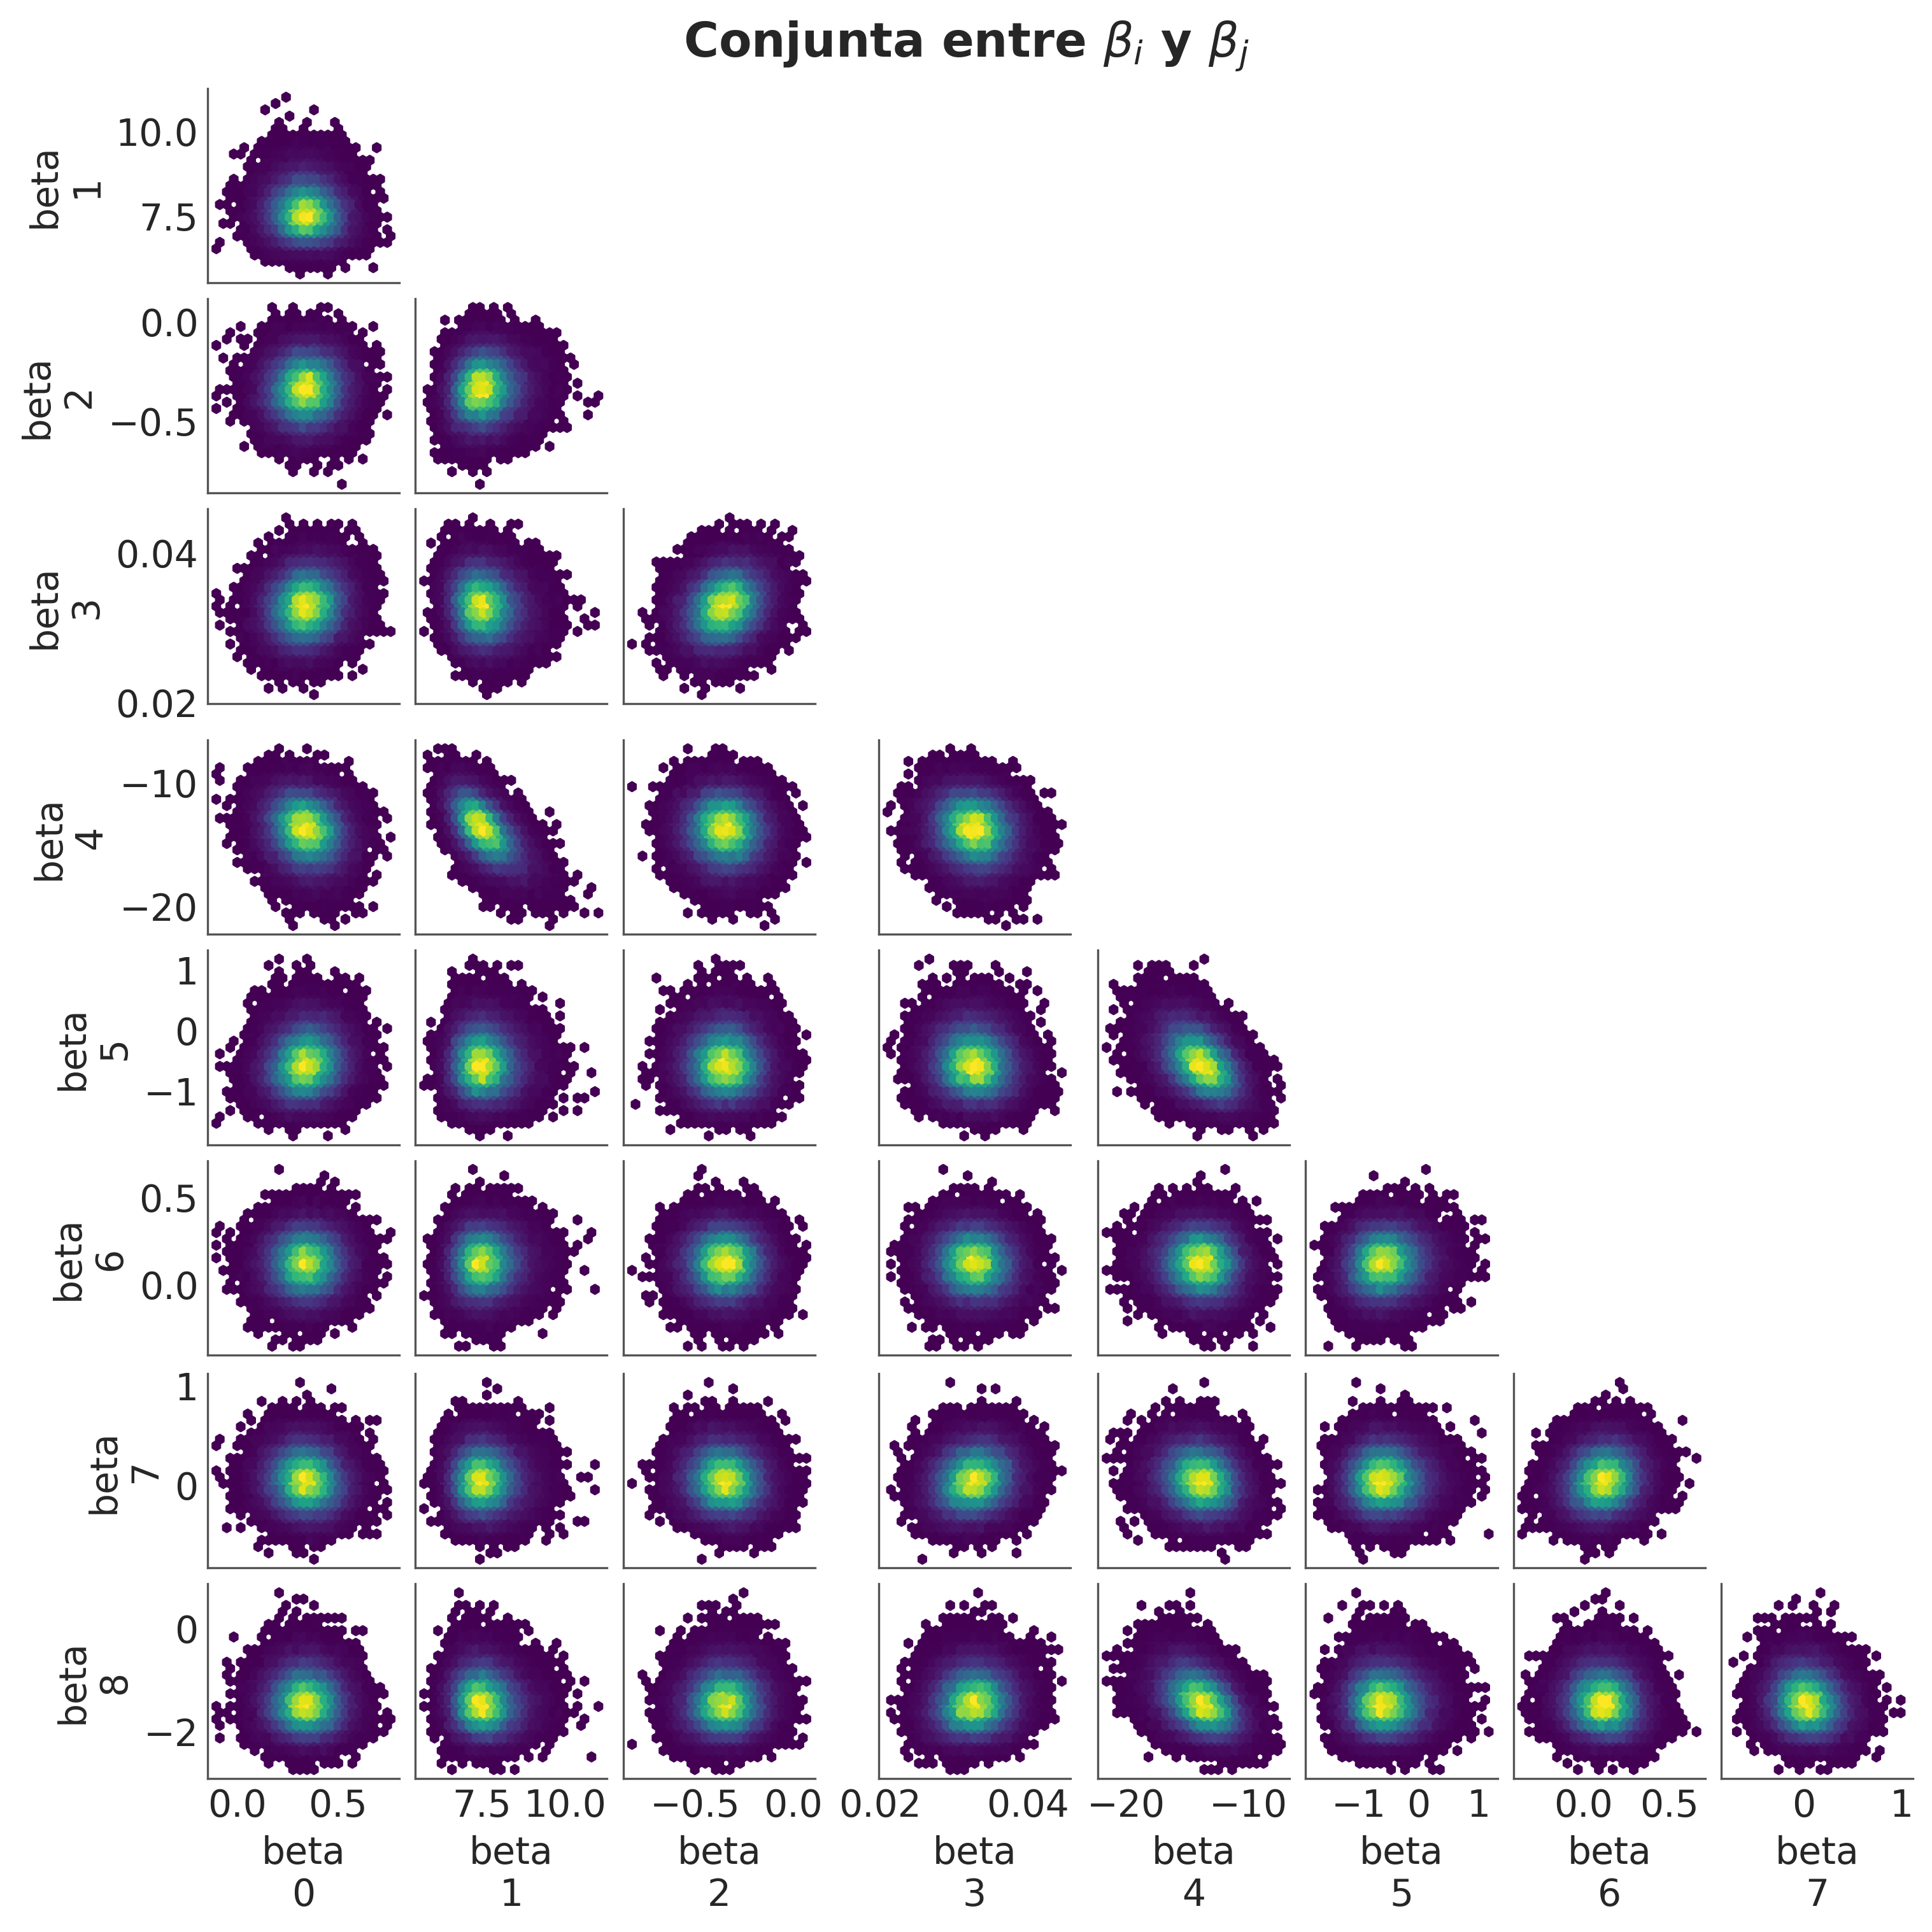

In [94]:
az.plot_pair(
    az_data,
    kind="hexbin",
    figsize=(10, 10),
    textsize=14,
    backend_kwargs={"alpha": 0.5}
)
plt.suptitle(r"Conjunta entre $\beta_i$ y $\beta_j$")
plt.show()